In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings

import os
from timevqvae.generation import TrainedModelSampler
from timevqvae.utils import get_data,  load_yaml_param_settings, set_seed
from typing import List
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import scipy.stats as st
sns.set(style="whitegrid")

In [2]:
config="../configs/config.yaml"
dataset_file = "../data/real/OpenSky_EHAM_LIMC.pkl"
model_save_dir = "../saved_models"
route = "EHAM-LIMC"
use_fidelity_enhancer=True

config = load_yaml_param_settings(config)
config["dataset"]["file"] = dataset_file
config["logger"]["model_save_dir"] = model_save_dir


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load the numpy matrix of the test samples
features = config["dataset"]["features"]
batch_size = config["evaluation"]["batch_size"]

train_data_loader, test_data_loader, scalar = get_data(
    dataset_file, features, batch_size
)
X_train, X_test, Y_train, Y_test = (
    train_data_loader.dataset.X.numpy(),
    test_data_loader.dataset.X.numpy(),
    train_data_loader.dataset.Y,
    test_data_loader.dataset.Y,
)
n_classes = len(np.unique(Y_train))
_, in_channels, input_length = X_train.shape


n_train_samples_per_class = dict(Counter(train_data_loader.dataset.Y.flatten()))

# print("n_train_samples_per_class:", n_train_samples_per_class)

seed = 42
set_seed(seed)

dataset_name = os.path.basename(config["dataset"]["file"]).split(".")[0]
stage1_ckpt_fname = os.path.join(model_save_dir, dataset_name, "stage1.ckpt")
stage2_ckpt_fname = os.path.join(model_save_dir, dataset_name, "stage2.ckpt")
stage3_ckpt_fname = os.path.join(model_save_dir, dataset_name, "stage3.ckpt")
fcn_ckpt_fname = os.path.join(model_save_dir, dataset_name, "fcn.ckpt")

In [3]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (5932, 4, 4633), X_test: (660, 4, 4633)


In [4]:
evaluation = TrainedModelSampler(
    stage1_ckpt_fname=stage1_ckpt_fname,
    stage2_ckpt_fname=stage2_ckpt_fname,
    stage3_ckpt_fname=stage3_ckpt_fname,
    fcn_ckpt_fname=fcn_ckpt_fname,
    input_length=input_length,
    in_channels=in_channels,
    n_classes=n_classes,
    batch_size=batch_size,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    device=device,
    config=config,
    use_fidelity_enhancer=use_fidelity_enhancer,
    feature_extractor_type=config["evaluation"]["feature_extractor_type"],
    do_evaluate=True,
).to(device)

X_gen, X_gen_R, Y_gen = [], [], []
for class_idx, n_samples in n_train_samples_per_class.items():
    # print(f"sampling synthetic data | class_idx: {class_idx}...")
    (_, _, xhat_tmp), xhat_R_tmp = evaluation.sample(
        n_samples=n_samples, kind="conditional", class_index=class_idx
    )
    X_gen.append(xhat_tmp)
    X_gen_R.append(xhat_R_tmp)
    Y_gen.append(torch.Tensor([class_idx] * n_samples))
X_gen = torch.cat(X_gen).float()  # (b c l)
X_gen_R = torch.cat(X_gen_R).float()  # (b c l)
Y_gen = torch.cat(Y_gen)[:, None].long()  # (b 1)
print("self.X_gen.shape:", X_gen.shape)
print("self.X_gen_R.shape:", X_gen_R.shape)
print("self.Y_gen.shape:", Y_gen.shape)



self.X_gen.shape: torch.Size([5932, 4, 4633])
self.X_gen_R.shape: torch.Size([5932, 4, 4633])
self.Y_gen.shape: torch.Size([5932, 1])


In [5]:
z_train = evaluation.z_train
z_test = evaluation.z_test
z_rec_train = evaluation.compute_z_rec("train")
z_rec_test = evaluation.compute_z_rec("test")
zhat = evaluation.compute_z_gen(X_gen)
z_svq_train, x_prime_train = evaluation.compute_z_svq("train")
z_svq_test, x_prime_test = evaluation.compute_z_svq("test")
zhat_R = evaluation.compute_z_gen(X_gen_R)

In [6]:
# shape
print(f"z_train.shape: {z_train.shape}, z_test.shape: {z_test.shape}")
print(f"z_rec_train.shape: {z_rec_train.shape}, z_rec_test.shape: {z_rec_test.shape}")
print(f"zhat.shape: {zhat.shape}")
print(f"z_svq_train.shape: {z_svq_train.shape}, x_prime_train.shape: {x_prime_train.shape}")
print(f"z_svq_test.shape: {z_svq_test.shape}, x_prime_test.shape: {x_prime_test.shape}")
print(f"zhat_R.shape: {zhat_R.shape}")

z_train.shape: (5932, 2000), z_test.shape: (660, 2000)
z_rec_train.shape: (5932, 2000), z_rec_test.shape: (660, 2000)
zhat.shape: (5932, 2000)
z_svq_train.shape: (5932, 2000), x_prime_train.shape: (5932, 4, 4633)
z_svq_test.shape: (660, 2000), x_prime_test.shape: (660, 4, 4633)
zhat_R.shape: (5932, 2000)


### Visual Inpsection: PCA

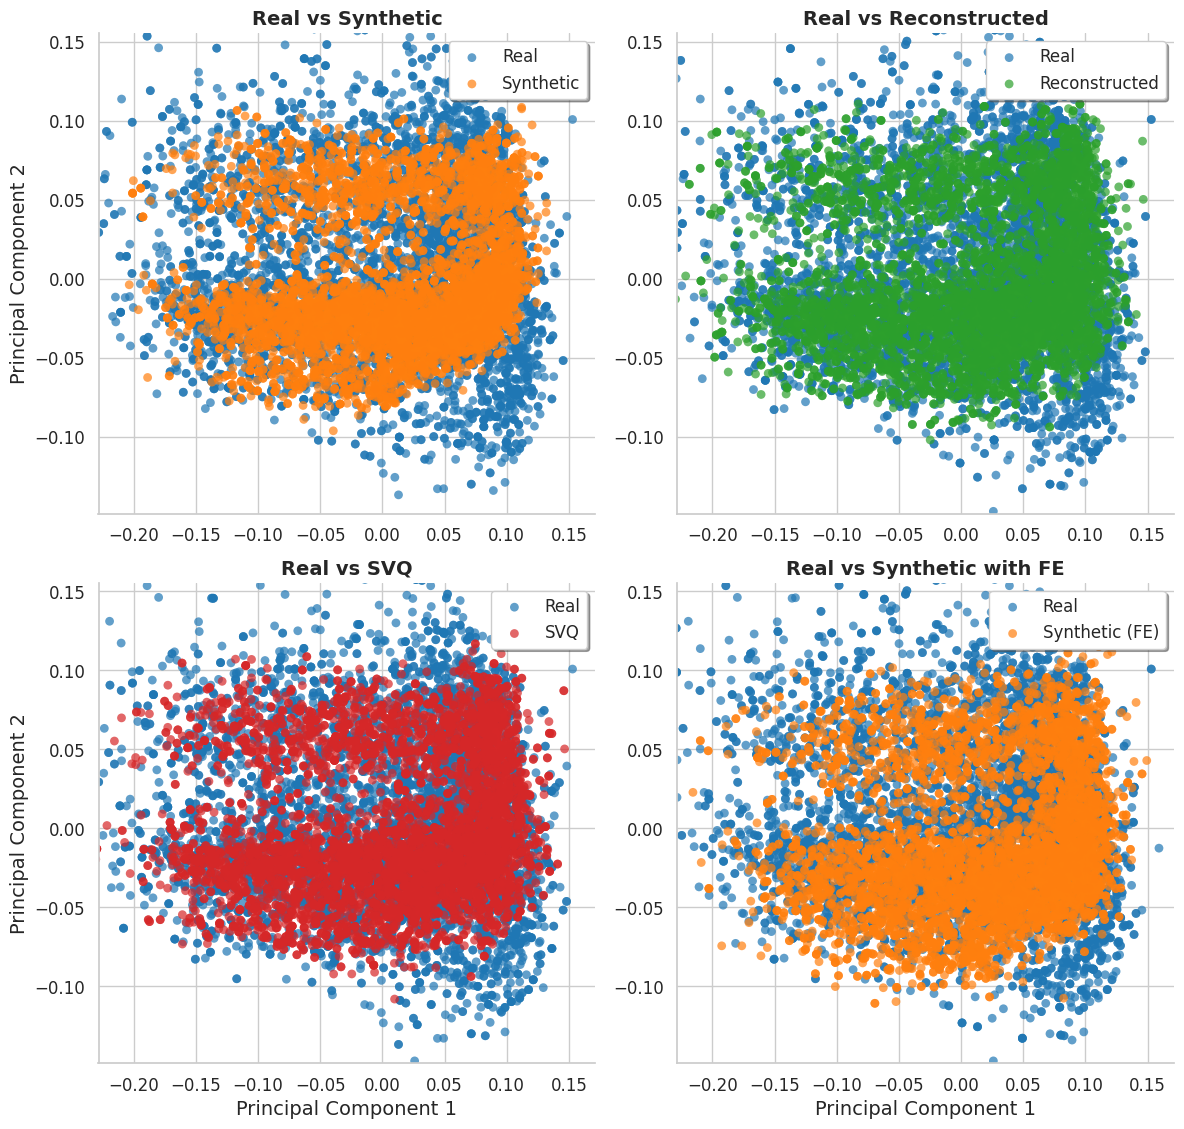

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List

def log_pca(
    self,
    Zs: List[np.ndarray],
    labels: List[str],
    n_plot_samples: int = 1000,
    ax=None,
    show_x_label=False,
    show_y_label=False,
    colors=["#1f77b4", "#ff7f0e"]  # Updated default colors
):
    assert len(Zs) == len(labels)
    
    # Set up the plot style
    sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.9', 'grid.linestyle': '--'})
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Verdana', 'Geneva', 'sans-serif']
    plt.rcParams['font.family'] = 'sans-serif'
    
    for i, (Z, label) in enumerate(zip(Zs, labels)):
        # Sample data points for PCA transformation
        ind = np.random.choice(range(Z.shape[0]), size=n_plot_samples, replace=True)
        Z_embed = self.pca.transform(Z[ind])
        
        # Scatter plot with improved aesthetics
        ax.scatter(Z_embed[:, 0], Z_embed[:, 1], alpha=0.7, s=40, color=colors[i], label=label, edgecolor='none')
    
    # Adjust plot limits and padding
    xpad = (self.xmax_pca - self.xmin_pca) * 0.1
    ypad = (self.ymax_pca - self.ymin_pca) * 0.1
    ax.set_xlim(self.xmin_pca - xpad, self.xmax_pca + xpad)
    ax.set_ylim(self.ymin_pca - ypad, self.ymax_pca + ypad)
    
    # Set axis labels
    if show_x_label:
        ax.set_xlabel("Principal Component 1", fontsize=14)
    if show_y_label:
        ax.set_ylabel("Principal Component 2", fontsize=14)
    
    # Improve tick labels
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Enhance legend aesthetics
    ax.legend(loc="upper right", fontsize=12, frameon=True, fancybox=True, shadow=True, ncol=1)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Create subplots with a 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# fig.suptitle("PCA Analysis of Different Data Representations", fontsize=16, fontweight='bold', y=0.95)

# Custom color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
# colors = ["#1f77b4", "#d62728", "#2ca02c", "#ff7f0e"]

# Plot for each subplot
log_pca(evaluation, [z_train, zhat], ["Real", "Synthetic"], n_plot_samples=zhat.shape[0], ax=axs[0, 0], show_y_label=True, colors=colors[:2])
axs[0, 0].set_title("Real vs Synthetic", fontsize=14, fontweight='bold')

log_pca(evaluation, [z_train, z_rec_train], ["Real", "Reconstructed"], n_plot_samples=z_rec_train.shape[0], ax=axs[0, 1], colors=[colors[0], colors[2]])
axs[0, 1].set_title("Real vs Reconstructed", fontsize=14, fontweight='bold')

log_pca(evaluation, [z_train, z_svq_train], ["Real", "SVQ"], n_plot_samples=z_svq_train.shape[0], ax=axs[1, 0], show_x_label=True, show_y_label=True, colors=[colors[0], colors[3]])
axs[1, 0].set_title("Real vs SVQ", fontsize=14, fontweight='bold')

log_pca(evaluation, [z_train, zhat_R], ["Real", "Synthetic (FE)"], n_plot_samples=zhat_R.shape[0], ax=axs[1, 1], show_x_label=True, colors=[colors[0], colors[1]])
axs[1, 1].set_title("Real vs Synthetic with FE", fontsize=14, fontweight='bold')

# Adjust layout and save
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig(f"../.figures/pca_plot_{route}.png", bbox_inches='tight')
plt.show()

## Visual Inspection: t-SNE

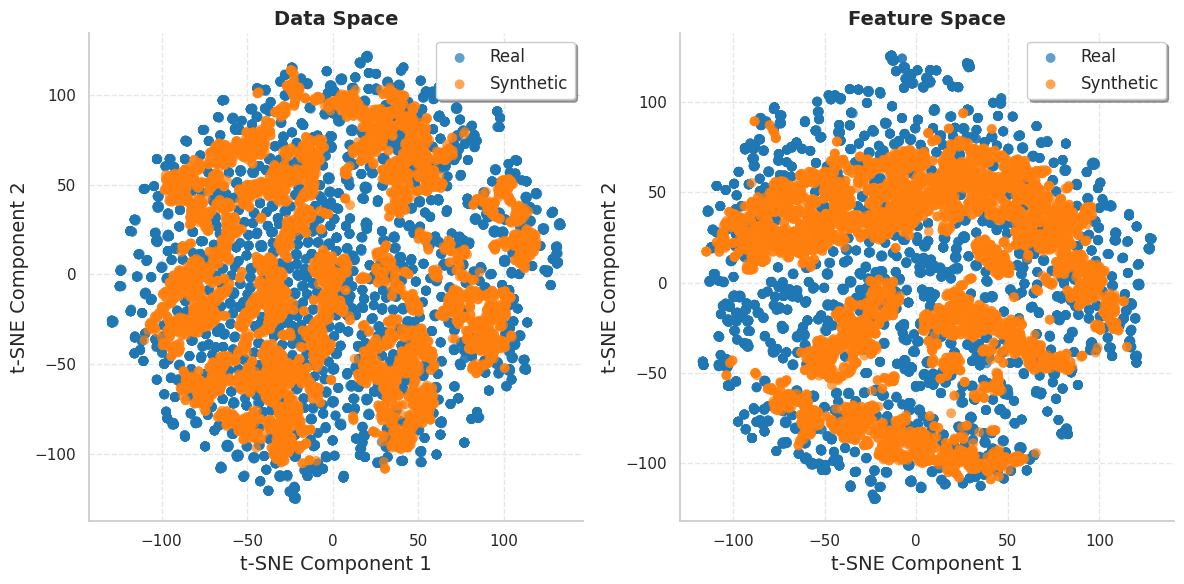

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.nn.functional as F
import seaborn as sns

def log_tsne(self, n_plot_samples: int, X_gen, z_train: np.ndarray, z_gen: np.ndarray, route: str):
    # Set up the plot style
    sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.9', 'grid.linestyle': '--'})
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Verdana', 'Geneva', 'sans-serif']
    plt.rcParams['font.family'] = 'sans-serif'

    # Interpolate X_gen to match the shape of X_test
    X_gen = F.interpolate(X_gen, size=self.X_test.shape[-1], mode="linear", align_corners=True)
    X_gen = X_gen.cpu().numpy()

    # Randomly sample indices for the test and generated data

    sample_ind_test = np.random.randint(0, self.X_test.shape[0], n_plot_samples)
    sample_ind_gen = np.random.randint(0, X_gen.shape[0], n_plot_samples)

    # Flatten the data for t-SNE (data space)
    X_test_flat = self.X_test[sample_ind_test].reshape(n_plot_samples, -1)
    X_gen_flat = X_gen[sample_ind_gen].reshape(n_plot_samples, -1)

    # Concatenate the test and generated data
    X = np.concatenate((X_test_flat, X_gen_flat), axis=0)
    labels = np.array(["Real"] * n_plot_samples + ["Synthetic"] * n_plot_samples)

    # Apply t-SNE to the data space
    X_embedded = TSNE(n_components=2, learning_rate="auto", init="random", random_state=42).fit_transform(X)

    # Flatten the latent space data for t-SNE
    z_test_flat = z_train[sample_ind_test].reshape(n_plot_samples, -1)
    z_gen_flat = z_gen[sample_ind_gen].reshape(n_plot_samples, -1)

    # Concatenate the latent space test and generated data
    Z = np.concatenate((z_test_flat, z_gen_flat), axis=0)

    # Apply t-SNE to the latent space
    Z_embedded = TSNE(n_components=2, learning_rate="auto", init="random", random_state=42).fit_transform(Z)

    # Create a single figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # fig.suptitle(f"t-SNE Visualization for Route: {route}", fontsize=16, fontweight='bold', y=1.02)

    # Custom color palette
    colors = ["#1f77b4", "#ff7f0e"]  # Blue for Real, Orange for Synthetic
    # colors = ["#1f77b4", "#d62728"]  # Blue for Real, Red for Synthetic

    # Plot t-SNE results for data space
    for label, color in zip(["Real", "Synthetic"], colors):
        mask = labels == label
        axes[0].scatter(X_embedded[mask, 0], X_embedded[mask, 1],
                        alpha=0.7, label=label, color=color, edgecolor='none', s=50)
    axes[0].set_xlabel("t-SNE Component 1", fontsize=14)
    axes[0].set_ylabel("t-SNE Component 2", fontsize=14)
    axes[0].set_title("Data Space", fontsize=14, fontweight='bold')
    axes[0].legend(loc="upper right", fontsize=12, frameon=True, fancybox=True, shadow=True)
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    # Plot t-SNE results for latent space
    for label, color in zip(["Real", "Synthetic"], colors):
        mask = labels == label
        axes[1].scatter(Z_embedded[mask, 0], Z_embedded[mask, 1],
                        alpha=0.7, label=label, color=color, edgecolor='none', s=50)
    axes[1].set_xlabel("t-SNE Component 1", fontsize=14)
    axes[1].set_ylabel("t-SNE Component 2", fontsize=14)
    axes[1].set_title("Feature Space", fontsize=14, fontweight='bold')
    axes[1].legend(loc="upper right", fontsize=12, frameon=True, fancybox=True, shadow=True)
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f"../.figures/tsne_plot_{route}.png", bbox_inches='tight')
    plt.show()

# Example usage
log_tsne(evaluation, n_plot_samples=X_gen.shape[0], X_gen=X_gen, z_train=z_train, z_gen=zhat, route=route)